In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pathlib 
import os
from scipy import signal

import torch

import PT_files.save_load as sl
from DnCNN_NP.layers  import relu#, np_BatchNorm2d, np_Conv2d

In [2]:
def pytorch_numpy_comparison(input_data,
                             pytorch_output,
                             numpy_output,
                             sample_idx):
    
    
    
    fig, ax = plt.subplots(1, 3, figsize=(24,20))
    vmin, vmax = np.percentile(input_data[sample_idx], (1,99))

    ax[0].imshow(pytorch_output[sample_idx][0], vmin=vmin, vmax=vmax, origin='lower', interpolation='none')
    ax[0].axis('off')
    ax[0].set_title('Pytorch BatchNorm', fontsize=30)
    ax[1].imshow(input_data[sample_idx][0],vmin=vmin, vmax=vmax, origin='lower', interpolation='none')
    ax[1].axis('off')
    ax[1].set_title('Input Sample', fontsize=30)
    ax[2].imshow(numpy_output[sample_idx][0], vmin=vmin, vmax=vmax, origin='lower', interpolation='none')
    ax[2].axis('off')
    ax[2].set_title('Numpy BatchNorm', fontsize=30)
    
    
def full_grid_pass_window(dataset, model, model_params, samp_idx):
    
    full = np.empty((1, 1, 6000,6000))
    count = np.empty((1, 1, 6000,6000))
    
    noise_data = dataset[0]
    param_name = model_params
    print('pass 1')
    
    current_dir = pathlib.Path().resolve()
    model_params_path = current_dir / 'Model_params'
    assert model_params_path.exists()
    model_path = model_params_path / param_name
    print('pass 2')
    
    model = model()
    model.to(device)
    model.load_state_dict(torch.load(str(model_path)))
    model.eval();
    print('pass 3')
    # telling pytorch this is for inference and not learning, so keeps the weights unchanged
    with torch.no_grad():
        
        print('pass 4')
        torch.cuda.empty_cache()
        test_noise = torch.as_tensor(noise_data[samp_idx:samp_idx+1,:,:, :])
        test_noise = test_noise.to(device)

        print('pass 5')
        output = model(test_noise)
        print('pass 6')
        resid_img = output.detach().cpu().numpy()
        print('pass 7')

        full[:, :, :, :] += resid_img

    return full

In [3]:
PATH = pathlib.Path(os.getenv('PSCRATCH'))
DATA = PATH / 'DESI_dn' /'Model_params'
assert DATA.exists()
name = '6k_model_wb_e800_lys20_58feat.pth'

# weights = np.load(DATA / name)
weights = torch.load(str(DATA / name))


#Load the actual data that we're working on & print the shape of this data
test_data = sl.NERSC_load('test_data_40%_6000.npy')
sample = test_data[0]
print('Shape of test set=', sample.shape)

Shape of test set= (108, 1, 6000, 6000)


In [4]:
weights.keys()

odict_keys(['layers.0.0.weight', 'layers.0.0.bias', 'layers.1.0.weight', 'layers.1.0.bias', 'layers.1.1.weight', 'layers.1.1.bias', 'layers.1.1.running_mean', 'layers.1.1.running_var', 'layers.1.1.num_batches_tracked', 'layers.2.0.weight', 'layers.2.0.bias', 'layers.2.1.weight', 'layers.2.1.bias', 'layers.2.1.running_mean', 'layers.2.1.running_var', 'layers.2.1.num_batches_tracked', 'layers.3.0.weight', 'layers.3.0.bias', 'layers.3.1.weight', 'layers.3.1.bias', 'layers.3.1.running_mean', 'layers.3.1.running_var', 'layers.3.1.num_batches_tracked', 'layers.4.0.weight', 'layers.4.0.bias', 'layers.4.1.weight', 'layers.4.1.bias', 'layers.4.1.running_mean', 'layers.4.1.running_var', 'layers.4.1.num_batches_tracked', 'layers.5.0.weight', 'layers.5.0.bias', 'layers.5.1.weight', 'layers.5.1.bias', 'layers.5.1.running_mean', 'layers.5.1.running_var', 'layers.5.1.num_batches_tracked', 'layers.6.0.weight', 'layers.6.0.bias', 'layers.6.1.weight', 'layers.6.1.bias', 'layers.6.1.running_mean', 'layer

In [5]:
def np_Conv2d(input_data, weights_dict, prefix, stride=1, padding="same", dilation=1):
    
    batch_size, input_channels, height, width = input_data.shape # (N, Cin, Hin, Win)
    
    weight = weights_dict[str(prefix) + 'weight']
    bias = weights_dict[str(prefix) + 'bias']
    
    kernel_size = weight[0][0].shape
    output_channels = len(weight)
    
    # Convert string padding into numerical padding
    # Using strings allow for one variable to account for padding & mode (see signal.correlated2d)
    mode = padding
    if mode == "same":
        padding = 1
    elif mode == "valid":
        padding = 0
    
    height_out = ((height + (2*padding) - dilation * (kernel_size[0] - 1) - 1) / stride) + 1
    height_out = int(height_out)
    width_out = ((width + (2*padding) - dilation * (kernel_size[1] - 1) - 1) / stride) + 1
    width_out = int(width_out)

    output = np.empty((batch_size, output_channels, height_out, width_out))
    
    for i in range(batch_size):
        for j in range(output_channels):
            output[i, j, :, :] = bias[j].detach().cpu().numpy() + signal.correlate2d(input_data[i][0], weight[j][0].detach().cpu().numpy(), mode=mode)
    
    return output


def np_BatchNorm2d(input_data, prefix, weights_dict, epsilon=1e-5):
    
    x = input_data
    
    gamma = weights_dict[str(prefix) + 'weight'].detach().cpu().numpy().reshape(-1, 1, 1)
    beta = weights_dict[str(prefix) + 'bias'].detach().cpu().numpy().reshape(-1, 1, 1)
    mean = weights_dict[str(prefix) + 'running_mean'].detach().cpu().numpy().reshape(-1, 1, 1)
    var = weights_dict[str(prefix) + 'running_var'].detach().cpu().numpy().reshape(-1, 1, 1)
        
        
    output = ((x - mean) / np.sqrt(var + epsilon)) * gamma + beta
    return output

In [6]:
def load_weights(data, prefix, weights_dict):
    
    if type(prefix) != str:
        raise Exception("The prefix must be a string!")
                        
    if prefix.endswith('0.'):
        conv_layer_output = np_Conv2d(input_data=data,
                                      weights_dict=weights_dict,
                                      prefix=prefix)
        return conv_layer_output
    
    elif prefix.endswith('1.'):
        batch_layer_output = np_BatchNorm2d(x=data,
                                            prefix=prefix,
                                            weights_dict=weights_dict)
        return batch_layer_output
    
    elif prefix.endswith('19.'):
        conv_layer_output = np_Conv2d(input_data=data,
                                      weights_dict=weights_dict,
                                      prefix=prefix)
        return conv_layer_output

In [7]:
from collections import OrderedDict

# Replace the last part of the key that describes what layer it is
# part of and replaces it with empty space
layers_list = [x.replace('weight', '').replace('bias', '').replace('running_mean', '').replace('running_var', '').replace('num_batches_tracked', '') for x in weights.keys()]
# Convert this list which has duplicated elements due to removing
# identifying elements ie. for the first conv layer we had
# layers.0.0.weight & layers.0.0.bias, but now after removing them we
# have layers.0.0 & layers.0.0
# The code below deletes the duplicated elements
layers_list = list(OrderedDict.fromkeys(layers_list))
print(layers_list)

['layers.0.0.', 'layers.1.0.', 'layers.1.1.', 'layers.2.0.', 'layers.2.1.', 'layers.3.0.', 'layers.3.1.', 'layers.4.0.', 'layers.4.1.', 'layers.5.0.', 'layers.5.1.', 'layers.6.0.', 'layers.6.1.', 'layers.7.0.', 'layers.7.1.', 'layers.8.0.', 'layers.8.1.', 'layers.9.0.', 'layers.9.1.', 'layers.10.0.', 'layers.10.1.', 'layers.11.0.', 'layers.11.1.', 'layers.12.0.', 'layers.12.1.', 'layers.13.0.', 'layers.13.1.', 'layers.14.0.', 'layers.14.1.', 'layers.15.0.', 'layers.15.1.', 'layers.16.0.', 'layers.16.1.', 'layers.17.0.', 'layers.17.1.', 'layers.18.0.', 'layers.18.1.', 'layers.19.']


In [8]:
# for i in range(len(layers_list)-2):
#     print(layers_list[i+1])

In [14]:
conv_start = time.perf_counter()
output = np_Conv2d(input_data=sample[:1],
                   weights_dict=weights,
                   prefix=layers_list[0])
conv_end = time.perf_counter()
print('Conv layer', conv_end-conv_start, 'seconds')


conv_start = time.perf_counter()
output = np_Conv2d(input_data=output,
                           weights_dict=weights,
                           prefix=layers_list[1])
conv_end = time.perf_counter()
print('Conv layer', conv_end-conv_start, 'seconds')


batch_start = time.perf_counter()
output = np_BatchNorm2d(input_data=output,
                            weights_dict=weights,
                            prefix=layers_list[2])
batch_end = time.perf_counter()
output = relu(output)
print('Batch layer', batch_end-batch_start, 'seconds')

              
conv_start = time.perf_counter()
output = np_Conv2d(input_data=output,
                           weights_dict=weights,
                           prefix=layers_list[3])
conv_end = time.perf_counter()
print('Conv layer', conv_end-conv_start, 'seconds')

batch_start = time.perf_counter()
output = np_BatchNorm2d(input_data=output,
                            weights_dict=weights,
                            prefix=layers_list[4])
batch_end = time.perf_counter()
output = relu(output)
print('Batch layer', batch_end-batch_start, 'seconds')
              
              
              
conv_start = time.perf_counter()
output = np_Conv2d(input_data=output,
                           weights_dict=weights,
                           prefix=layers_list[5])
conv_end = time.perf_counter()
print('Conv layer', conv_end-conv_start, 'seconds')

batch_start = time.perf_counter()
output = np_BatchNorm2d(input_data=output,
                            weights_dict=weights,
                            prefix=layers_list[6])
batch_end = time.perf_counter()
output = relu(output)
print('Batch layer', batch_end-batch_start, 'seconds')

conv_start = time.perf_counter()
output = np_Conv2d(input_data=output,
                           weights_dict=weights,
                           prefix=layers_list[7])
conv_end = time.perf_counter()
print('Conv layer', conv_end-conv_start, 'seconds')

batch_start = time.perf_counter()
output = np_BatchNorm2d(input_data=output,
                            weights_dict=weights,
                            prefix=layers_list[8])
batch_end = time.perf_counter()
output = relu(output)
print('Batch layer', batch_end-batch_start, 'seconds')

conv_start = time.perf_counter()
output = np_Conv2d(input_data=output,
                           weights_dict=weights,
                           prefix=layers_list[9])
conv_end = time.perf_counter()
print('Conv layer', conv_end-conv_start, 'seconds')

              
batch_start = time.perf_counter()
output = np_BatchNorm2d(input_data=output,
                            weights_dict=weights,
                            prefix=layers_list[10])
batch_end = time.perf_counter()
output = relu(output)
print('Batch layer', batch_end-batch_start, 'seconds')

              
              
conv_start = time.perf_counter()
output = np_Conv2d(input_data=output,
                           weights_dict=weights,
                           prefix=layers_list[11])
conv_end = time.perf_counter()
print('Conv layer', conv_end-conv_start, 'seconds')

batch_start = time.perf_counter()
output = np_BatchNorm2d(input_data=output,
                            weights_dict=weights,
                            prefix=layers_list[12])
batch_end = time.perf_counter()
output = relu(output)
print('Batch layer', batch_end-batch_start, 'seconds')


              
conv_start = time.perf_counter()
output = np_Conv2d(input_data=output,
                           weights_dict=weights,
                           prefix=layers_list[13])
conv_end = time.perf_counter()
print('Conv layer', conv_end-conv_start, 'seconds')

              
batch_start = time.perf_counter()
output = np_BatchNorm2d(input_data=output,
                            weights_dict=weights,
                            prefix=layers_list[14])
batch_end = time.perf_counter()
output = relu(output)
print('Batch layer', batch_end-batch_start, 'seconds')

conv_start = time.perf_counter()
output = np_Conv2d(input_data=output,
                           weights_dict=weights,
                           prefix=layers_list[15])
conv_end = time.perf_counter()
print('Conv layer', conv_end-conv_start, 'seconds')

              
batch_start = time.perf_counter()
output = np_BatchNorm2d(input_data=output,
                            weights_dict=weights,
                            prefix=layers_list[16])
batch_end = time.perf_counter()
output = relu(output)
print('Batch layer', batch_end-batch_start, 'seconds')

              
              
conv_start = time.perf_counter()
output = np_Conv2d(input_data=output,
                           weights_dict=weights,
                           prefix=layers_list[17])
conv_end = time.perf_counter()
print('Conv layer', conv_end-conv_start, 'seconds')

              
              
batch_start = time.perf_counter()
output = np_BatchNorm2d(input_data=output,
                            weights_dict=weights,
                            prefix=layers_list[18])
batch_end = time.perf_counter()
output = relu(output)
print('Batch layer', batch_end-batch_start, 'seconds')


conv_start = time.perf_counter()
output = np_Conv2d(input_data=output,
                           weights_dict=weights,
                           prefix=layers_list[19])
conv_end = time.perf_counter()
print('Conv layer', conv_end-conv_start, 'seconds')

              
              
batch_start = time.perf_counter()
output = np_BatchNorm2d(input_data=output,
                            weights_dict=weights,
                            prefix=layers_list[20])
batch_end = time.perf_counter()
output = relu(output)
print('Batch layer', batch_end-batch_start, 'seconds')


conv_start = time.perf_counter()
output = np_Conv2d(input_data=output,
                           weights_dict=weights,
                           prefix=layers_list[21])
conv_end = time.perf_counter()
print('Conv layer', conv_end-conv_start, 'seconds')

              
              
batch_start = time.perf_counter()
output = np_BatchNorm2d(input_data=output,
                            weights_dict=weights,
                            prefix=layers_list[22])
batch_end = time.perf_counter()
output = relu(output)
print('Batch layer', batch_end-batch_start, 'seconds')


conv_start = time.perf_counter()
output = np_Conv2d(input_data=output,
                           weights_dict=weights,
                           prefix=layers_list[23])
conv_end = time.perf_counter()
print('Conv layer', conv_end-conv_start, 'seconds')
              
              
batch_start = time.perf_counter()
output = np_BatchNorm2d(input_data=output,
                            weights_dict=weights,
                            prefix=layers_list[24])
batch_end = time.perf_counter()
output = relu(output)
print('Batch layer', batch_end-batch_start, 'seconds')
              

conv_start = time.perf_counter()
output = np_Conv2d(input_data=output,
                           weights_dict=weights,
                           prefix=layers_list[25])
conv_end = time.perf_counter()
print('Conv layer', conv_end-conv_start, 'seconds')
              
              
batch_start = time.perf_counter()
output = np_BatchNorm2d(input_data=output,
                            weights_dict=weights,
                            prefix=layers_list[26])
batch_end = time.perf_counter()
output = relu(output)
print('Batch layer', batch_end-batch_start, 'seconds')


conv_start = time.perf_counter()
output = np_Conv2d(input_data=output,
                           weights_dict=weights,
                           prefix=layers_list[27])
conv_end = time.perf_counter()
print('Conv layer', conv_end-conv_start, 'seconds')
              
              
batch_start = time.perf_counter()
output = np_BatchNorm2d(input_data=output,
                            weights_dict=weights,
                            prefix=layers_list[28])
batch_end = time.perf_counter()
output = relu(output)
print('Batch layer', batch_end-batch_start, 'seconds')

conv_start = time.perf_counter()
output = np_Conv2d(input_data=output,
                           weights_dict=weights,
                           prefix=layers_list[29])
conv_end = time.perf_counter()
print('Conv layer', conv_end-conv_start, 'seconds')
              
              
              
              
batch_start = time.perf_counter()
output = np_BatchNorm2d(input_data=output,
                            weights_dict=weights,
                            prefix=layers_list[30])
batch_end = time.perf_counter()
output = relu(output)
print('Batch layer', batch_end-batch_start, 'seconds')


conv_start = time.perf_counter()
output = np_Conv2d(input_data=output,
                           weights_dict=weights,
                           prefix=layers_list[31])
conv_end = time.perf_counter()
print('Conv layer', conv_end-conv_start, 'seconds')
              
              
              
batch_start = time.perf_counter()
output = np_BatchNorm2d(input_data=output,
                            weights_dict=weights,
                            prefix=layers_list[32])
batch_end = time.perf_counter()
output = relu(output)
print('Batch layer', batch_end-batch_start, 'seconds')


conv_start = time.perf_counter()
output = np_Conv2d(input_data=output,
                           weights_dict=weights,
                           prefix=layers_list[33])
conv_end = time.perf_counter()
print('Conv layer', conv_end-conv_start, 'seconds')
              
              
              
batch_start = time.perf_counter()
output = np_BatchNorm2d(input_data=output,
                            weights_dict=weights,
                            prefix=layers_list[34])
batch_end = time.perf_counter()
output = relu(output)
print('Batch layer', batch_end-batch_start, 'seconds')

    

conv_start = time.perf_counter()
output = np_Conv2d(input_data=output,
                           weights_dict=weights,
                           prefix=layers_list[35])
conv_end = time.perf_counter()
print('Conv layer', conv_end-conv_start, 'seconds')

              
              
batch_start = time.perf_counter()
output = np_BatchNorm2d(input_data=output,
                            weights_dict=weights,
                            prefix=layers_list[37])
batch_end = time.perf_counter()
output = relu(output)
print('Batch layer', batch_end-batch_start, 'seconds')
    

conv_start = time.perf_counter()
output = np_Conv2d(input_data=output,
                           weights_dict=weights,
                           prefix=layers_list[37])
conv_end = time.perf_counter()
print('Conv layer', conv_end-conv_start, 'seconds')

Conv layer 61.02711102302419 seconds
Conv layer 63.49673509300919 seconds
Batch layer 25.360057851008605 seconds
Conv layer 62.47572086501168 seconds
Batch layer 25.20298542402452 seconds
Conv layer 63.881072305026464 seconds
Batch layer 25.345183948986232 seconds


KeyboardInterrupt: 

In [ ]:
plt.imshow(output[0][0])

In [11]:
# 1st layer

import time 

output = np_Conv2d(input_data=sample[:1],
                   weights_dict=weights,
                   prefix=layers_list[0])

output = relu(output)


for i in range(len(layers_list)-2):
    
    if layers_list[i+1].endswith('0.'):
        
        conv_start = time.perf_counter()
        output = np_Conv2d(input_data=output,
                           weights_dict=weights,
                           prefix=layers_list[i+1])
        conv_end = time.perf_counter()
        print('Conv Layer', conv_end-conv_start, 'seconds')
        
    elif layers_list[i+1].endswith('1.'):
        
        batch_start = time.perf_counter()
        output = np_BatchNorm2d(input_data=output,
                                weights_dict=weights,
                                prefix=layers_list[i+1])
        output = relu(output)
        batch_end = time.perf_counter()
        print('Batch Layer', batch_end-batch_start, 'seconds')


output = np_Conv2d(input_data=output,
                   weights_dict=weights,
                   prefix=layers_list[-1])

Conv Layer 64.96868234901922 seconds
Batch Layer 32.9055719919852 seconds
Conv Layer 64.09523469401756 seconds
Batch Layer 31.545963359996676 seconds
Conv Layer 66.69565234996844 seconds
Batch Layer 30.97650143801002 seconds
Conv Layer 62.27537750697229 seconds
Batch Layer 32.84150863398099 seconds
Conv Layer 64.75775867199991 seconds
Batch Layer 32.42221926501952 seconds
Conv Layer 63.86903452302795 seconds
Batch Layer 31.691658274969086 seconds
Conv Layer 66.01920901599806 seconds
Batch Layer 30.85767441795906 seconds
Conv Layer 61.23703242902411 seconds
Batch Layer 31.696132535988 seconds
Conv Layer 61.38363751297584 seconds
Batch Layer 32.821852921973914 seconds
Conv Layer 61.42835111002205 seconds
Batch Layer 32.06110851600533 seconds
Conv Layer 67.2828773999936 seconds
Batch Layer 32.06524058798095 seconds
Conv Layer 64.03477394598303 seconds
Batch Layer 31.56302462698659 seconds
Conv Layer 62.49593822599854 seconds
Batch Layer 32.518785057996865 seconds
Conv Layer 64.35918465600

In [12]:
output.shape
output[0][0]

array([[-0.02869121, -0.03349543, -0.03269177, ..., -0.03265676,
        -0.03256562, -0.03074346],
       [-0.02880623, -0.02176519, -0.02141996, ..., -0.02140986,
        -0.02152639, -0.02576497],
       [-0.02915312, -0.02284033, -0.02345272, ..., -0.02346824,
        -0.02321174, -0.02718633],
       ...,
       [-0.02916658, -0.02288682, -0.02355822, ..., -0.02358123,
        -0.0233125 , -0.0272828 ],
       [-0.0292498 , -0.02327646, -0.02398995, ..., -0.02402493,
        -0.02369493, -0.02789586],
       [-0.02785992, -0.0164943 , -0.0179336 , ..., -0.01797075,
        -0.01794659, -0.02019483]])

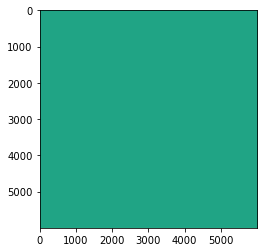

In [13]:
plt.imshow(output[0][0])

In [9]:
def model_flow(input_data, weights_dict, prefix_list):
    
    output = np_Conv2d(input_data=input_data,
                   weights_dict=weights_dict,
                   prefix=prefix_list[0])


    for i in range(len(prefix_list)-2):
        print(prefix_list[i+1])

        if prefix_list[i+1].endswith('0.'):

            output = np_Conv2d(input_data=output,
                               weights_dict=weights_dict,
                               prefix=prefix_list[i+1])

        elif layers_list[i+1].endswith('1.'):
            output = np_BatchNorm2d(input_data=output,
                                    weights_dict=weights_dict,
                                    prefix=prefix_list[i+1])

    output = np_Conv2d(input_data=output,
                       weights_dict=weights_dict,
                       prefix=prefix_list[-1])
    
    return output

%timeit output = model_flow(input_data=sample[:1], weights_dict=weights, prefix_list=layers_list)


layers.1.0.


KeyboardInterrupt: 

In [ ]:
# 1st layer
output = np_Conv2d(input_data=sample[:1],
                   weights_dict=weights,
                   prefix=layers_list[0])

[np_Conv2d(input_data=output,
           weights_dict=weights,
           prefix=layers_list[i+1])
 
if layers_list[i+1].endswith('0.') else
 
 np_BatchNorm2d(input_data=output,
                weights_dict=weights,
                prefix=layers_list[i+1])
 
for i in range(len(layers_list)-2)]

output = np_Conv2d(input_data=output, 
                   weights_dict=weights,
                   prefix=layers_lust[-1])

In [ ]:
plt.imshow(output[0][0])